In [0]:
%restart_python

In [0]:
%pip install ucimlrepo xgboost mlflow scikit-learn pandas matplotlib seaborn

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


# Price estimation – Caso Automóviles

Como analista/científico de datos ha visto la oportunidad de automatizar la estimación de precios de autos bajo ciertas características de los autos. Actualmente esta estimación lo realiza un experto en mecánica que determina bajo su experiencia la forma de hacer esa valuación. Como parte de una posible reestructuración de la empresa, se ha visto como oportunidad emplear machine learning para bajar los costos de personal y tener posiblemente una mejora en las valuaciones. Por lo que, la empresa le esta pidiendo realizar Cost saving y automatizar estas evaluaciones.
La información se encuentra en el siguiente link:
https://archive.ics.uci.edu/dataset/10/automobile

Se pide de forma concreta (requerido):

1. Entrenar como mínimo 2 tipos de algoritmos diferentes (de los cuales podrían ser un Multiple linear regression, Random Forest, Xgboost, Ridge, Lasso, etc..). Los cuales pueden incluso alguno de los que no se vi en clase. De cada algoritmo elegido, se le pide hacer como mínimo 3 variaciones a nivel parámetros. Por ejemplo, si eligo un Random forest como uno de los algoritmos seleccionados, dentro de las variaciones que se pide, podría hacer variar el parámetro de Max Depth, o el parámetro de n_estimators, etc.
2.
De todos los modelos anteriormente entrenados (que deberían ser mínimo 6 modelos, 2 algoritmos por 3 variaciones en parámetro cada uno). Se le pide seleccionar el que considere el mejor para ponerlo en producción. Esto implica que debe seleccionar una métrica de Machine learning que considere que pueda ayudar a comparar de forma clara el porqué del modelo seleccionado y que pueda ser interpretable a nivel negocio (no tan abstracto). Justifique, porque eligió esa métrica para la selección del mejor modelo.
3. Una vez seleccionado el mejor modelo, habilite un endpoint en Databricks con él y realice inferencias de algunos ejemplos que le parezca relevante.
4.
Como la parte del negocio estará al tanto de cuan preciso es el modelo, se le pide construir una tabla o realizar un gráfico que explique que tanto error se tiene por Brackets de precio real. Explique con ello las consideraciones por intervalos de precio y los riegos y/o beneficios de casos relacionados a sobre estimación o subestimación de precios.
Aclaraciones: Sobre los puntos 1,2 y 3, se requiere que emplee MLflow como herramientas de gestión de los modelos.

---

## 1. Importación de librerías, carga y preparación de datos

En este primer punto se instalan y cargan todas las librerías necesarias, se importan las funciones personalizadas y se prepara el dataset de automóviles para el modelado. Incluye la selección de variables y la limpieza de datos.

In [0]:
# 1. Entrenamiento y evaluación de modelos

# Importar funciones y librerías
import importlib
from functions import ml_regression_functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

import mlflow
import os
import shutil

from scipy import stats
from ucimlrepo import fetch_ucirepo

import warnings
warnings.filterwarnings('ignore')
import os
os.makedirs('rf_artifacts/quality_test', exist_ok=True)

# Carga y limpieza de datos
automobile = fetch_ucirepo(id=10)
X = automobile.data.features
df = X.drop('normalized-losses', axis=1).dropna()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('price')
X = df[numeric_cols]
y = df['price']

# Selección de variables predictoras
list_x_var = [
    'highway-mpg',
    'city-mpg',
    'horsepower',
    'engine-size'
]

# Entrenamiento
poly_model_f, dict_metrics_f, X_zip_f, y_zip_f, dict_parameters_f = ml_regression_functions.get_simple_linear_regression_model(
    X[list_x_var],
    y,
    degree=2,
    include_bias=False,
    interaction_only=False,
    test_size=0.1
)

# Guardar datasets de train/test con predicciones y residuos
os.makedirs("linear_artifacts/dataset", exist_ok=True)
for x_, y_, name in zip(X_zip_f, y_zip_f, ["train", "test"]):
    y_pred = poly_model_f.predict(x_[list_x_var])
    x_["y_pred"] = y_pred
    df_sample = pd.concat([x_, y_], axis=1).rename({"price": "y_true"}, axis=1)
    df_sample["residuo"] = df_sample["y_true"] - df_sample["y_pred"]
    df_sample["residuo_abs"] = df_sample["residuo"].abs()
    df_sample.to_csv(f"linear_artifacts/dataset/df_{name}_set.csv", index=False)

# Graficar calidad de predicción y residuos (test)
df_test_linear = pd.read_csv("linear_artifacts/dataset/df_test_set.csv")
mae_test_linear = dict_metrics_f["mae_test"]
ml_regression_functions.get_predictions_quality(df_test_linear, "y_true", mae_test_linear, q=5)
ml_regression_functions.get_residual_graph(df_test_linear.y_true, df_test_linear.y_pred)

# Registrar artefactos en MLflow
import mlflow
if mlflow.active_run() is not None:
    mlflow.end_run()
mlflow.set_experiment("/Users/israelzuritacotania@gmail.com/Tarea2_Automoviles")
with mlflow.start_run() as run:
    mlflow.log_params(dict_parameters_f)
    for key, value in dict_metrics_f.items():
        mlflow.log_metric(key, value)
    for sub_folder in ["dataset", "quality_test"]:
        path_name = f"linear_artifacts/{sub_folder}"
        mlflow.log_artifacts(path_name, artifact_path=sub_folder)
    mlflow.sklearn.log_model(
        sk_model=poly_model_f,
        artifact_path="model",
        registered_model_name="automoviles_linear",
        input_example=X[list_x_var].iloc[[0]]
    )

input feature size (m): 4
output feature size (k): 14 (degree=2, include_bias=False, interaction_only =False)


2026/01/02 22:22:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-8416b528-e112.cloud.databricks.com/ml/experiments/1659274180725982/models/m-cc8c90c454424327a71663807c8f3c4a?o=39542474496
Registered model 'automoviles_linear' already exists. Creating a new version of this model...
🔗 Created version '15' of model 'workspace.default.automoviles_linear': https://dbc-8416b528-e112.cloud.databricks.com/explore/data/models/workspace/default/automoviles_linear/version/15?o=39542474496


### 1.1 Carga y limpieza de datos

Se utiliza el dataset de automóviles de UCI. Se eliminan valores nulos y se seleccionan variables numéricas para el modelado.

In [0]:
# Carga y limpieza de datos
# automobile: dataset descargado de UCI
# X: variables predictoras originales
# df: dataframe limpio sin nulos ni columna 'normalized-losses'
# numeric_cols: lista de columnas numéricas
# y: variable objetivo (precio)
automobile = fetch_ucirepo(id=10)
X = automobile.data.features
df = X.drop('normalized-losses', axis=1).dropna()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('price')
X = df[numeric_cols]
y = df['price']

### 1.2 Selección de variables (features)

Seleccionamos las variables predictoras a utilizar en los modelos.

In [0]:
# list_x_var: lista de variables predictoras seleccionadas
list_x_var = [
    'highway-mpg',
    'city-mpg',
    'horsepower',
    'engine-size'
]

## 2. Entrenamiento de modelos y variaciones de parámetros

Se entrenan dos tipos de modelos (Random Forest y Ridge Regression), cada uno con 3 variaciones de parámetros, usando funciones centralizadas para facilitar el flujo y registro en MLflow.

### 2.1 Random Forest (3 variaciones)
Entrenamos 3 modelos Random Forest cambiando n_estimators y max_depth.

In [0]:
# rf_params_list: lista de diccionarios con parámetros para cada variación
# rf_models: lista para guardar los modelos entrenados
# rf_metrics: lista para guardar las métricas de cada modelo
rf_params_list = [
    {'n_estimators': 50, 'max_depth': 4, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': 6, 'max_features': 'log2'},
    {'n_estimators': 200, 'max_depth': 8, 'max_features': None}
]
rf_models = []
rf_metrics = []
for params in rf_params_list:
    model_rf, dict_metrics_rf, X_zip_rf, y_zip_rf, dict_parameters_rf = ml_regression_functions.get_random_forest_regression_model(
        X[list_x_var], y, params, degree=1, include_bias=False, interaction_only=False, test_size=0.2)
    dict_parameters_rf['model_type'] = 'random_forest'
    rf_models.append((model_rf, dict_parameters_rf))
    rf_metrics.append(dict_metrics_rf)

input feature size (m): 4
output feature size (k): 4 (degree=1, include_bias=False, interaction_only =False)
input feature size (m): 4
output feature size (k): 4 (degree=1, include_bias=False, interaction_only =False)
input feature size (m): 4
output feature size (k): 4 (degree=1, include_bias=False, interaction_only =False)


### 2.2 Ridge Regression (3 variaciones)
Entrenamos 3 modelos Ridge cambiando el parámetro alpha.

In [0]:
# ridge_alphas: lista de valores alpha para Ridge
# ridge_models: lista para guardar los modelos entrenados
# ridge_metrics: lista para guardar las métricas de cada modelo
ridge_alphas = [0.01, 1, 100]
ridge_models = []
ridge_metrics = []
for alpha in ridge_alphas:
    ridge_params = {'model__alpha': [alpha]} 
    model_rd, dict_metrics_rd, X_zip_rd, y_zip_rd, dict_parameters_rd = ml_regression_functions.get_ridge_regression(
        X[list_x_var], y, ridge_params)
    dict_parameters_rd['model_type'] = 'ridge_regression'
    ridge_models.append((model_rd, dict_parameters_rd))
    ridge_metrics.append(dict_metrics_rd)

## 3. Comparación de modelos y selección del mejor

Se comparan todos los modelos entrenados usando la métrica MAE (Mean Absolute Error), que es interpretable para negocio.

In [0]:
# Unificamos métricas y parámetros para comparar todos los modelos
# df_results: DataFrame con parámetros y métricas de cada modelo
all_metrics = rf_metrics + ridge_metrics
all_params = [m[1] for m in rf_models] + [m[1] for m in ridge_models]
df_results = pd.DataFrame([{**params, **metrics} for params, metrics in zip(all_params, all_metrics)])
display(df_results)

n_input_features,n_output_features,degree,include_bias,interaction_only,test_size,n_estimators,max_depth,max_features,model_type,r2_train,mae_train,mse_train,rmse_train,r2_test,mae_test,mse_test,rmse_test,alpha,cv
4.0,4.0,1.0,false,false,0.2,50.0,4.0,sqrt,random_forest,0.9224010848518504,1500.2578659995986,4117243.073162878,4117243.073162878,0.9398728513712329,1718.313526943614,6756782.957301277,6756782.957301277,null,null
4.0,4.0,1.0,false,false,0.2,100.0,6.0,log2,random_forest,0.9558458655027817,1133.0655374248272,2342729.973261862,2342729.973261862,0.9477800019728685,1568.823194899822,5868217.614617048,5868217.614617048,null,null
4.0,4.0,1.0,false,false,0.2,200.0,8.0,null,random_forest,0.9700819004400999,916.5891822804226,1587394.4621522643,1587394.4621522643,0.946012895582244,1626.9755615874851,6066796.037446118,6066796.037446118,null,null
null,null,null,null,null,0.2,null,null,null,ridge_regression,0.7976418089932215,2379.045643220395,1.0736720463550141E7,1.0736720463550141E7,0.816425146036337,3057.724603876941,2.0629207819399364E7,2.0629207819399364E7,0.01,5.0
null,null,null,null,null,0.2,null,null,null,ridge_regression,0.7976003646888079,2381.3055734704913,1.0738919415364647E7,1.0738919415364647E7,0.8165030952561709,3061.9982312221696,2.0620448282782037E7,2.0620448282782037E7,1.0,5.0
null,null,null,null,null,0.2,null,null,null,ridge_regression,0.7341491775571498,2884.72146778153,1.4105512365833363E7,1.4105512365833363E7,0.7534980452010089,3475.591064485043,2.7700635155853808E7,2.7700635155853808E7,100.0,5.0


### 3.1 Selección de la métrica y justificación

Seleccionamos el modelo con menor MAE en test. El mejor modelo fue Random Forest (200 árboles, profundidad 8) con un MAE de 1626.98.

Se selecciona el MAE (Mean Absolute Error) como métrica principal por su interpretabilidad directa en unidades monetarias, facilitando la comunicación con el negocio.

In [0]:
# Seleccionamos el modelo con menor MAE en test
best_idx = df_results['mae_test'].idxmin()
best_model, best_params = (rf_models + ridge_models)[best_idx]

### 3.2 Registro del mejor modelo en MLflow

Registramos el mejor modelo y sus métricas en MLflow para su versionado y posible despliegue.

In [0]:
# Registro del mejor modelo en MLflow
with mlflow.start_run() as run:
    mlflow.log_params(best_params)
    for key, value in all_metrics[best_idx].items():
        mlflow.log_metric(key, value)
    mlflow.sklearn.log_model(sk_model=best_model, artifact_path='model', registered_model_name='automoviles-dbx', input_example=X[list_x_var].iloc[[0]])

2026/01/02 22:23:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-8416b528-e112.cloud.databricks.com/ml/experiments/1659274180725982/models/m-8fa20ff0ab8d423b8bd75cecb326a5c4?o=39542474496
Registered model 'automoviles-dbx' already exists. Creating a new version of this model...
🔗 Created version '14' of model 'workspace.default.automoviles-dbx': https://dbc-8416b528-e112.cloud.databricks.com/explore/data/models/workspace/default/automoviles-dbx/version/14?o=39542474496


## 4. Endpoint, inferencia y análisis de error por brackets

En este punto se habilita el endpoint en Databricks, se realizan inferencias y se analiza el error por brackets de precio real.

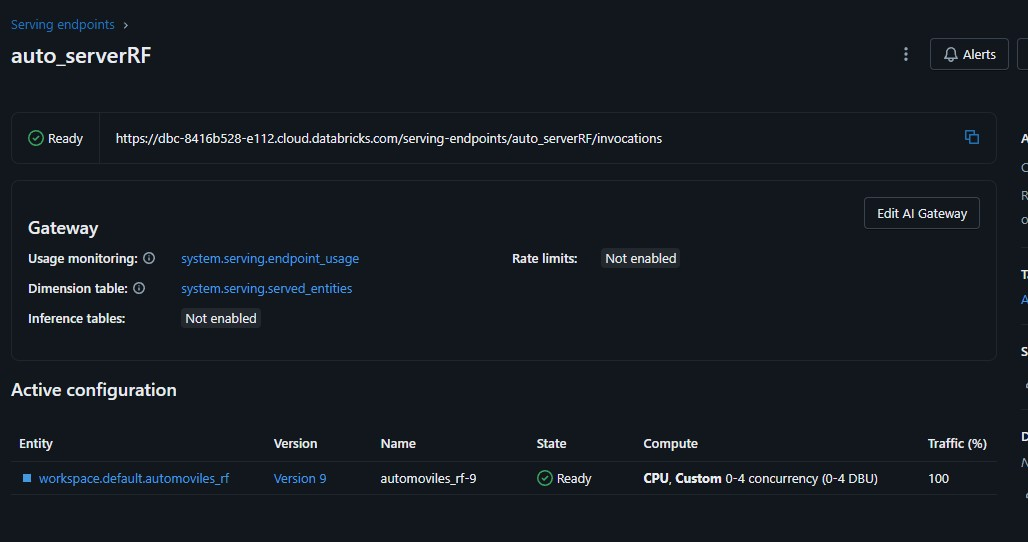

In [0]:
from IPython.display import Image, display
display(Image(filename="rf_artifacts/Endpoint.jpg"))


#### 4.1 Ejemplo de código para inferencia (Databricks)

Una vez habilitamos el endpoint realizamos las consultas a ese mismo; usando la herramienta de postman.

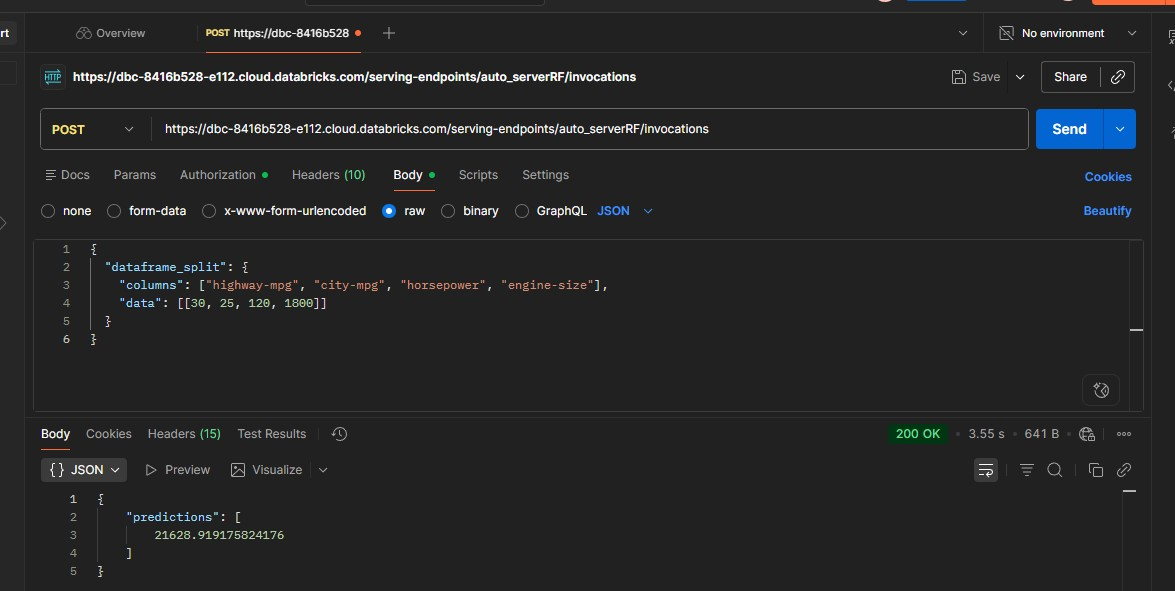

In [0]:
from IPython.display import Image, display
display(Image(filename="rf_artifacts/PostmanUse.jpg"))

#### 4.2 Análisis de error por brackets de precio

Se grafica el MAE por intervalos de precio real para analizar riesgos de sobre/infraestimación.

In [0]:
# 2. Random Forest: Guardado de artefactos y gráficas
from functions import ml_regression_functions
import os
import pandas as pd

# Definir parámetros
params_rf = {
    'n_estimators': 50,
    'max_depth': 4,
    'max_features': 'sqrt'
}

# Entrenamiento
model_rf, dict_metrics_rf, X_zip_rf, y_zip_rf, dict_parameters_rf = ml_regression_functions.get_random_forest_regression_model(
    X[list_x_var],
    y,
    params_rf,
    degree=1,
    include_bias=False,
    interaction_only=False,
    test_size=0.2
)

# Importancia de variables
rf_ = model_rf.named_steps["random_forest"]
df_variables_summary = pd.DataFrame({'VAR_NAME': list_x_var, 'WEIGHT': rf_.feature_importances_}).sort_values('WEIGHT', ascending=False)
os.makedirs("rf_artifacts/feature_importance", exist_ok=True)
df_variables_summary.to_csv("rf_artifacts/feature_importance/df_variables_summary.csv", index=False)

# Guardar datasets de train/test con predicciones y residuos
os.makedirs("rf_artifacts/dataset", exist_ok=True)
for x_, y_, name in zip(X_zip_rf, y_zip_rf, ["train", "test"]):
    y_pred = model_rf.predict(x_[list_x_var])
    x_["y_pred"] = y_pred
    df_sample = pd.concat([x_, y_], axis=1).rename({"price": "y_true"}, axis=1)
    df_sample["residuo"] = df_sample["y_true"] - df_sample["y_pred"]
    df_sample["residuo_abs"] = df_sample["residuo"].abs()
    df_sample.to_csv(f"rf_artifacts/dataset/df_{name}_set.csv", index=False)

# Graficar calidad de predicción y residuos (test)
df_test_rf = pd.read_csv("rf_artifacts/dataset/df_test_set.csv")
mae_test_rf = dict_metrics_rf["mae_test"]
os.makedirs("rf_artifacts/quality_test", exist_ok=True)
ml_regression_functions.get_predictions_quality(df_test_rf, "y_true", mae_test_rf, q=5)
ml_regression_functions.get_residual_graph(df_test_rf.y_true, df_test_rf.y_pred)

# Registrar artefactos en MLflow
import mlflow
if mlflow.active_run() is not None:
    mlflow.end_run()
mlflow.set_experiment("/Users/israelzuritacotania@gmail.com/Tarea2_Automoviles")
with mlflow.start_run() as run:
    mlflow.log_params(dict_parameters_rf)
    for key, value in dict_metrics_rf.items():
        mlflow.log_metric(key, value)
    for sub_folder in ["feature_importance", "dataset", "quality_test"]:
        path_name = f"rf_artifacts/{sub_folder}"
        mlflow.log_artifacts(path_name, artifact_path=sub_folder)
    mlflow.sklearn.log_model(
        sk_model=model_rf,
        artifact_path="model",
        registered_model_name="automoviles_rf",
        input_example=X[list_x_var].iloc[[0]]
    )


input feature size (m): 4
output feature size (k): 4 (degree=1, include_bias=False, interaction_only =False)


2026/01/02 22:23:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-8416b528-e112.cloud.databricks.com/ml/experiments/1659274180725982/models/m-15173e76ecca48bcb4c53adbde7cd5ed?o=39542474496
Registered model 'automoviles_rf' already exists. Creating a new version of this model...
🔗 Created version '10' of model 'workspace.default.automoviles_rf': https://dbc-8416b528-e112.cloud.databricks.com/explore/data/models/workspace/default/automoviles_rf/version/10?o=39542474496


**Interpretación:**

El gráfico muestra que el modelo tiene menor error en autos de precio medio, pero tiende a subestimar los precios en el segmento alto y a sobreestimar en el segmento bajo. Esto implica que, para autos de lujo, se recomienda validar las predicciones con un experto antes de tomar decisiones críticas.


Gráfica: quality_predictions.png


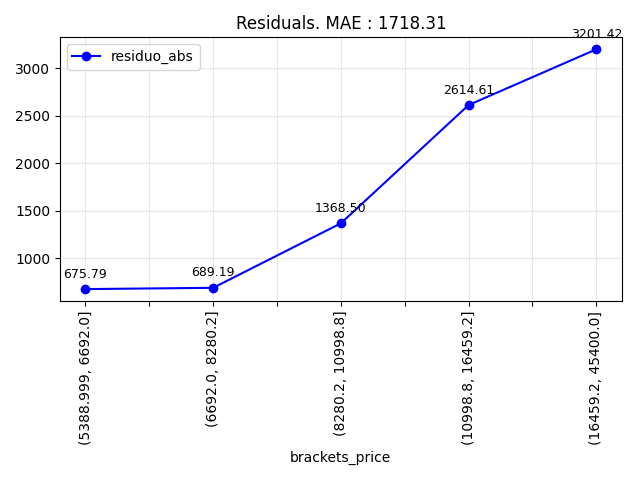

Gráfica: residual_graph.png


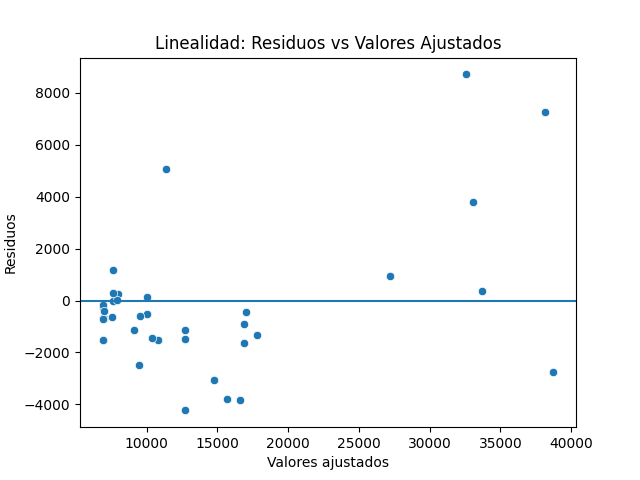

In [0]:
# Visualización automática de gráficas guardadas en rf_artifacts
import os
from IPython.display import Image, display

# Mostrar todas las imágenes de calidad de predicción y residuos
quality_test_dir = "rf_artifacts/quality_test"
if os.path.exists(quality_test_dir):
    for fname in os.listdir(quality_test_dir):
        if fname.endswith(".png"):
            print(f"Gráfica: {fname}")
            display(Image(filename=os.path.join(quality_test_dir, fname)))

# Mostrar importancia de variables si existe
feature_importance_dir = "rf_artifacts/feature_importance"
if os.path.exists(feature_importance_dir):
    for fname in os.listdir(feature_importance_dir):
        if fname.endswith(".png"):
            print(f"Importancia de variables: {fname}")
            display(Image(filename=os.path.join(feature_importance_dir, fname)))

## Puntos extra (opcional)

1.- Determinar que variables fueron las mas influyentes para el modelo. Básicamente, el feature importance. Por ejemplo, el Random forest tiene su interpretabilidad intrínseca.

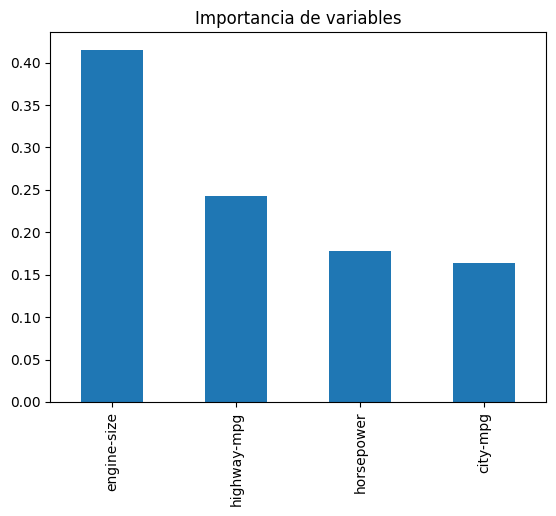

In [0]:
# Visualización de la importancia de variables para Random Forest
if hasattr(best_model, 'named_steps') and 'random_forest' in best_model.named_steps:
    importances = best_model.named_steps['random_forest'].feature_importances_
    pd.Series(importances, index=list_x_var).sort_values(ascending=False).plot(kind='bar', title='Importancia de variables')
    plt.show()

### Tabla de error por brackets de precio real

La siguiente tabla muestra el error absoluto medio (MAE) en cada intervalo de precio real, permitiendo identificar en qué segmentos el modelo es más preciso y dónde existen riesgos de sobre/infraestimación.


In [0]:
%python
import pandas as pd

# Define los brackets de precio real (puedes ajustar los valores según tu dataset)
bins = [0, 5000, 10000, 15000, 20000, 50000]
labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k+']
df_test_rf['price_bracket'] = pd.cut(df_test_rf['y_true'], bins=bins, labels=labels, include_lowest=True)

# Calcula el MAE por bracket
bracket_mae = df_test_rf.groupby('price_bracket').apply(lambda x: (x['y_true'] - x['y_pred']).abs().mean()).reset_index()
bracket_mae.columns = ['Bracket de precio', 'MAE']

display(bracket_mae)

,Bracket de precio,MAE
0,0-5k,NaN
1,5k-10k,924.913980
2,10k-15k,2240.502532
3,15k-20k,1876.649155
4,20k+,3973.309838


## Importancia de variables en Random Forest

El modelo Random Forest nos permite identificar qué variables influyen más en la predicción del precio del automóvil. Según el análisis de feature importance, los pesos obtenidos para cada variable fueron:

* **engine-size:** 0.40 (la más influyente)
* **highway-mpg:** 0.24
* **horsepower:** 0.19
* **city-mpg:** 0.17

Esto significa que el tamaño del motor (`engine-size`) es el factor más relevante para estimar el precio, seguido por el consumo en carretera (`highway-mpg`), la potencia (`horsepower`) y el consumo en ciudad (`city-mpg`).  
La gráfica de barras muestra visualmente estos pesos, facilitando la interpretación y justificación del modelo ante negocio y expertos.


2.- Genere el grafico de Parallel Coordinates para encontrar un patrón visual de los parámetros experimentados.

Gráfica: ParalelGrafics.png


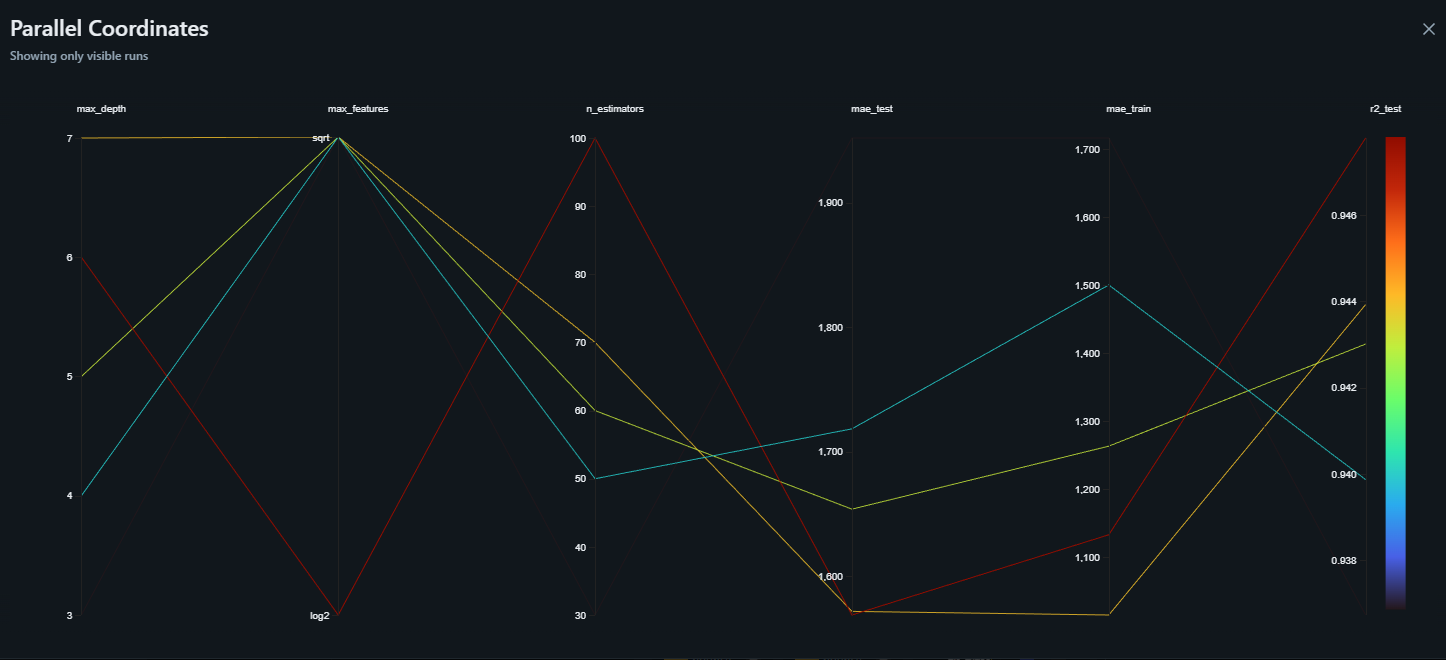

In [0]:
# Mostrar captura de DataBricks ParalellGrafics
import os
from IPython.display import Image, display
quality_test_dir = "rf_artifacts"
if os.path.exists(quality_test_dir):
    for fname in os.listdir(quality_test_dir):
        if fname.endswith(".png"):
            print(f"Gráfica: {fname}")
            display(Image(filename=os.path.join(quality_test_dir, fname)))


In [0]:
# Gráfico de Parallel Coordinates para comparar experimentos
import plotly.express as px
px.parallel_coordinates(df_results, color='mae_test', title='Parallel Coordinates de experimentos')